# Import Libraries

In [1]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import zipfile


2025-06-23 02:19:55.642147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750645195.920681      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750645196.000794      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
zip_path = "/kaggle/input/dogs-vs-cats/train.zip"
extract_path = "/kaggle/working/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

train_dir = "/kaggle/working/train"

print(f" Extracted training images to: {extract_path}")


 Extracted training images to: /kaggle/working/


# 3. Load VGG16 Model


In [3]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)


2025-06-23 02:21:24.332835: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 4. Feature Extraction using VGG16

In [4]:
def extract_features(image_path):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array, verbose=0)
    return features.flatten()


# 5. Load Image Paths


In [5]:
cat_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir) if img.startswith("cat")]
dog_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir) if img.startswith("dog")]

cat_images = cat_images[:10000]
dog_images = dog_images[:10000]

image_paths = cat_images + dog_images
labels = [0]*len(cat_images) + [1]*len(dog_images)


#  6. Extract Features


In [6]:
X = []
for path in tqdm(image_paths, desc="🔍 Extracting features"):
    feat = extract_features(path)
    X.append(feat)

X = np.array(X)
y = np.array(labels)
print(" Features shape:", X.shape)


🔍 Extracting features: 100%|██████████| 20000/20000 [1:06:01<00:00,  5.05it/s]


 Features shape: (20000, 8192)


# 7. Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"🔀 Split: {X_train.shape[0]} train | {X_test.shape[0]} test")


🔀 Split: 16000 train | 4000 test


#  8. Train SVM


In [8]:
clf = LinearSVC(C=1.0, max_iter=2000)
clf.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=2000)

# 9. Evaluate


In [9]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n Accuracy: {accuracy*100:.2f}%")




 Accuracy: 95.10%


# 10. Classification Report

In [10]:
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))


 Classification Report:
              precision    recall  f1-score   support

         Cat       0.95      0.95      0.95      2019
         Dog       0.95      0.95      0.95      1981

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



# 11. Confusion Matrix

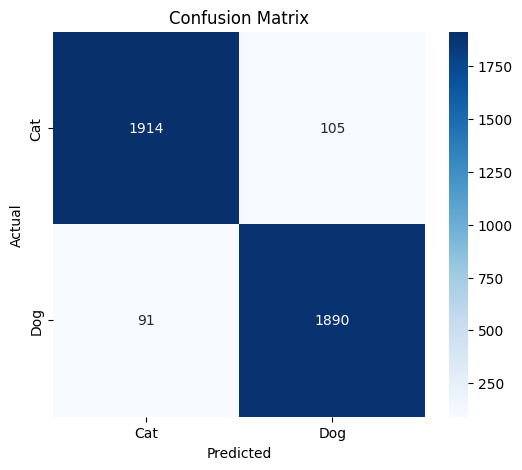

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
